In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from src.viz import plot_histograms

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] == 300

False

In [139]:
# reading the dataset
df = pd.read_csv('../data/raw/house_prices.csv')
df.sample(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
1811,Super built-up Area,Ready To Move,Koramangala,2 BHK,Saace P,1300,2.0,3.0,110.0
9966,Super built-up Area,18-Jun,Panathur,2 BHK,NaN,1007,2.0,1.0,64.0
2217,Super built-up Area,Ready To Move,Sarjapur Road,2 BHK,Adeatlm,1215,2.0,2.0,110.0
4007,Built-up Area,Ready To Move,"Sarjapur Road,",4 BHK,NaN,2425,4.0,3.0,173.0
1295,Super built-up Area,Ready To Move,Banashankari Stage V,3 BHK,NaN,1300,2.0,1.0,58.5


In [140]:
# checking the shape of the data
df.shape

(13320, 9)

There are 13320 rows and 9 columns

In [141]:
# checking the dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


There are 3 numerical columns and 6 non-numerical columns in the dataset.

In [142]:
# looking at the summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


Bath: 
- Most properties have between 1 to 3 bathrooms, with a median of 2. 
- There is a property with an unusually high number of bathrooms (maximum of 40), suggesting a potential outlier.

Balcony:
- The majority of properties have 1 to 2 balconies, with a median of 2.
- The presence of properties with 0 balconies indicates that some units might not have a balcony.

Price:
- Prices vary widely, with a mean of approximately 112.57 and a large standard deviation of 148.97.
- The majority of properties have prices between 8 and 120, as indicated by the interquartile range (IQR).
- There is a substantial difference between the 75th percentile and the maximum price (3600), suggesting the presence of potential outliers.

# Data Cleaning 

There are 6 categorical columns and we cannot use categorical columns for linear regression.

- Dropping availability and society as they might not add anything to the model
- Dropping balcony column since it has a lot of missing values

In [143]:
# checking for missing values
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [144]:
# dropping availability and society column
df = df.drop(['availability','society','balcony'], axis=1)
# The rest of the missing values are really small amount incomparison to the entire size, hence dropping the null values
df = df.dropna()
df.head()

,area_type,location,size,total_sqft,bath,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,51.00


In [145]:
# fixed the issue of missing value
df.isnull().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

Fixing sqft column as we would need in numeric format

In [146]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

We can see that there are some record that contain ranges of values
need to detect none float value and take the average of the range for getting a mean value to worth with

In [147]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [148]:
df[~df['total_sqft'].apply(is_float)].sample(5)

,area_type,location,size,total_sqft,bath,price
12990,Super built-up Area,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000
2265,Super built-up Area,Old Madras Road,4 BHK,3630 - 3800,6.0,200.500
9814,Super built-up Area,Hebbal,4 BHK,2470 - 2790,5.0,188.000
6386,Super built-up Area,Whitefield,2 BHK,981 - 1249,2.0,34.555
1086,Plot Area,Narasapura,2 Bedroom,30Acres,2.0,29.500


There are some values that are in ranges and some that contains str like 142.84Sq. Meter

In [149]:
# creating a function to average the ranges
def convert_sqft(x):
    token = x.split('-')
    if len(token) == 2:
        return (float(token[0])+float(token[1]))/2
    try:
        return float(x)
    except: 
        return None

In [150]:
# applying the function
df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df.sample(5)

,area_type,location,size,total_sqft,bath,price
3823,Super built-up Area,Harlur,4 BHK,1884.0,4.0,120.0
10489,Built-up Area,Sarjapur,3 Bedroom,2690.0,3.0,295.0
4872,Super built-up Area,Hegde Nagar,3 BHK,2006.8,4.0,196.0
12929,Super built-up Area,Whitefield,2 BHK,1270.0,2.0,105.0
4174,Super built-up Area,Nehru Nagar,4 BHK,2342.0,3.0,115.0


In [153]:
# dropping these values as well
display(df.shape)
df = df.dropna()
df.shape

(13246, 6)

(13200, 6)

In [154]:
# cleaned the missing values
df.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

There are discrepancies in the size column as some contain the suffix BHK and some contain the suffix Bedroom

In [157]:
# displaying all the unique objects in size attribute
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [158]:
# creating a new column with just the numbers of bedrooms
df['bhk'] = df['size'].apply(lambda x:int(x.split(' ')[0]))
df = df.drop('size', axis=1)
df.head()

,area_type,location,total_sqft,bath,price,bhk
0,Super built-up Area,Electronic City Phase II,1056.0,2.0,39.07,2
1,Plot Area,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Built-up Area,Uttarahalli,1440.0,2.0,62.00,3
3,Super built-up Area,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Super built-up Area,Kothanur,1200.0,2.0,51.00,2


In [159]:
df.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

We can see there is a house which has 43 bedrooms, let's inspect that

In [160]:
# looking at all the records that have more than 20 bedrooms
df[df['bhk']>20]

,area_type,location,total_sqft,bath,price,bhk
1718,Super built-up Area,2Electronic City Phase II,8000.0,27.0,230.0,27
4684,Plot Area,Munnekollal,2400.0,40.0,660.0,43


So, logically if a 8000 sqft house accomodates 27 bedrooms, then a 2000 sqft house shhould not accomodate more than 43 bedrooms. this can definetely be a case of outlier or misinput

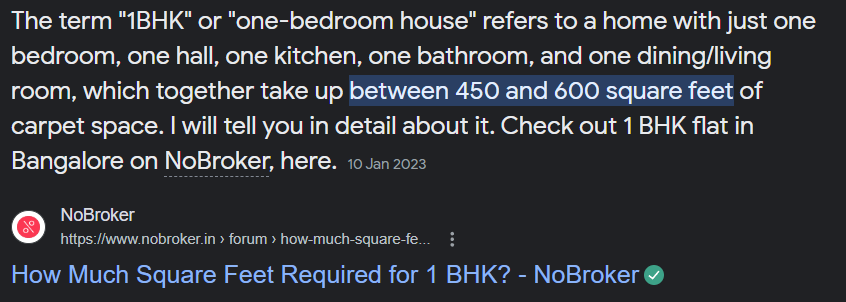

So to clean up discrepencies like that, we will be assuming that 1BHK has atleast 450 sqft area and then we will try to removed the unreasonable columns

In [168]:
df.head()

,area_type,location,total_sqft,bath,price,bhk
0,Super built-up Area,Electronic City Phase II,1056.0,2.0,39.07,2
1,Plot Area,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Built-up Area,Uttarahalli,1440.0,2.0,62.00,3
3,Super built-up Area,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Super built-up Area,Kothanur,1200.0,2.0,51.00,2


In [167]:
print(df.shape)
# removing all the column that have discrepencies in total_sqft
df = df[~df['total_sqft']/df['bhk']<450]
df.shape

,area_type,location,total_sqft,bath,price,bhk
8,Super built-up Area,Marathahalli,1310.0,3.0,63.25,3
9,Plot Area,Gandhi Bazar,1020.0,6.0,370.00,6
16,Super built-up Area,Bisuvanahalli,1180.0,3.0,48.00,3
25,Super built-up Area,Mangammanapalya,1250.0,3.0,56.00,3
26,Super built-up Area,Electronic City,660.0,1.0,23.10,2
...,...,...,...,...,...,...
13300,Plot Area,Hosakerehalli,1500.0,6.0,145.00,5
13303,Plot Area,Vidyaranyapura,774.0,5.0,70.00,5
13306,Plot Area,Rajarajeshwari Nagara,1200.0,5.0,325.00,4
13311,Plot Area,Ramamurthy Nagar,1500.0,9.0,250.00,7
